<a href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/challenges/challenge-one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 1: The banknote-authentication data set problem

We will perform a nearly realistic analysis of the data set bank note authentication that can be downloaded from https://archive.ics.uci.edu/dataset/267/banknote+authentication

## Data set description

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.
These features are:
1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous) 
3. curtosis of Wavelet Transformed image (continuous) 
4. entropy of image (continuous) 
5. class (integer)\

## Task description
We have a binary classification problem. The assignment can be divided in several parts:
    
    1. Load the data and pretreatment.
    2. Data exploring by Unsupervised Learning techniques.
    3. Construction of several models of Supervised Learning.

### 1. Data pretreatment

Load the data and look at it: It is needed some kind of scaling? Why? Are the data points sorted in the original data set? Can it generate problems? How can this be solved?

### Imports

In [1]:
import pandas as pd
from pprint import pprint as pp
from itertools import combinations
from zipfile import ZipFile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import numpy.linalg as LA
import plotly.express as px

from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer, normalize, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer

from zipfile import ZipFile
import wget
import os

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

### Configuration Options

In [3]:
# Path to file
FFILE = './dataset/data_banknote_authentication.txt'

# Check if the file / folder exists

if os.path.isfile(FFILE or 'banknote+authentication.zip'):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        wget.download("https://archive.ics.uci.edu/static/public/267/banknote+authentication.zip")
        zip = ZipFile('banknote+authentication.zip')
        zip.extractall()
        zip.close()
        os.replace("./data_banknote_authentication.txt", "./dataset/data_banknote_authentication.txt")
else:
    print("Either the file is missing or not readable, download it")
    wget.download("https://archive.ics.uci.edu/static/public/267/banknote+authentication.zip")
    zip = ZipFile('banknote+authentication.zip')
    zip.extractall()
    zip.close()
    os.replace("./data_banknote_authentication.txt", "./dataset/data_banknote_authentication.txt")

File already exists
File is readable


In [4]:
# Load the dataset using Pandas
df = pd.read_csv('./dataset/data_banknote_authentication.txt', header=None)
display(df.head())
display(df.describe())

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


,0,1,2,3,4
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [5]:
# Extracting the features (indipendent variables) and labels (dependent variable)
# Features (X) are taken from all columns except the last two
X = df.iloc[:, -2].values

# Labels (y) are taken from the third column (index 3, considering the 0-based index in Python)
y = df.iloc[:, -1].values

df.pop(4)
# x0 = intercept
# x1 = variance_WT 
# x2 = skewness_WT
# x3 = curtosis_WT
# x4 = entropy_img
df.rename(columns={0:'x1', 1:'x2', 2:'x3', 3:'x4'}, inplace=True)
features = ['x1', 'x2', 'x3', 'x4']
# df.insert(0, 'x0', np.ones((df.shape[0],1)))
df.insert(0, 'y', y)
label = y.astype(str)
display(df.head())

,y,x1,x2,x3,x4
0,0,3.62160,8.6661,-2.8073,-0.44699
1,0,4.54590,8.1674,-2.4586,-1.46210
2,0,3.86600,-2.6383,1.9242,0.10645
3,0,3.45660,9.5228,-4.0112,-3.59440
4,0,0.32924,-4.4552,4.5718,-0.98880


In [6]:
df.shape

(1372, 5)

In [7]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Esplorazione dati

In [8]:
display(df.dtypes)
vcounts = df['y'].value_counts()
vcounts

y       int64
x1    float64
x2    float64
x3    float64
x4    float64
dtype: object

0    762
1    610
Name: y, dtype: int64

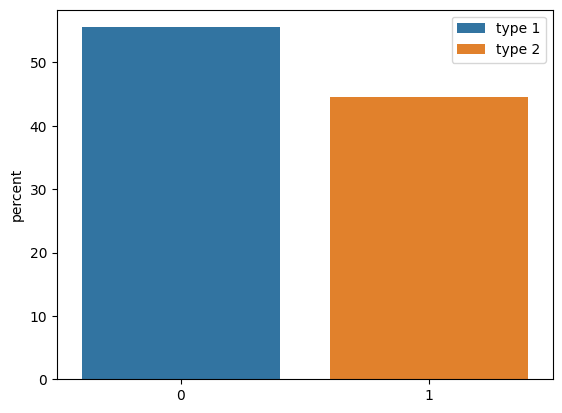

In [9]:
# ax = sns.countplot(x="y", data =df, palette='hls')
df_tmp = df
df_tmp['y'] = df_tmp['y'].astype(str)
ax = sns.countplot(x=y, data=df_tmp, hue="y", legend=True, stat='percent')
ax.legend(labels = ['type 1', 'type 2'])
        

plt.savefig("./figures/analisi_exp/count_plot")

In [10]:
pct_of_no_sub = vcounts[0]/(vcounts[0]+vcounts[1])
print("label uguali a 0: ", pct_of_no_sub*100)
pct_of_sub = vcounts[1]/(vcounts[0]+vcounts[1])
print("label uguali a 1: ", pct_of_sub*100)

label uguali a 0:  55.539358600583085
label uguali a 1:  44.460641399416915


Le nostre classi sono leggermente sbilanciate, ed il rapporto di etichette uguali a 1 è 44.46.

In [11]:
df.groupby('y').mean()

,x1,x2,x3,x4
y,,,,
0,2.276686,4.256627,0.796718,-1.147640
1,-1.868443,-0.993576,2.148271,-1.246641


##### Visualization

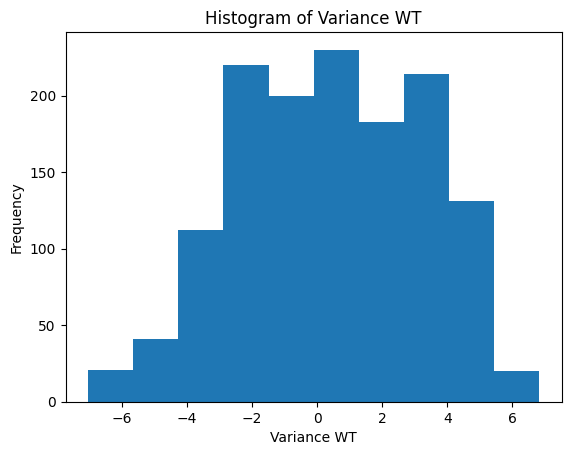

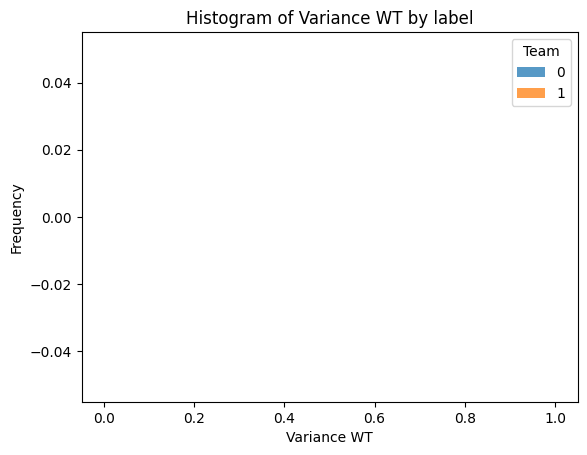

In [12]:
df.x1.hist(grid=False)

plt.title('Histogram of Variance WT')
plt.xlabel('Variance WT')
plt.ylabel('Frequency')
plt.savefig("./figures/analisi_exp/hist_variance_WT")
plt.show()

plt.hist(df.loc[df['y'] == 0, 'x1'], alpha=0.75, label='0')
plt.hist(df.loc[df['y'] == 1, 'x1'], alpha=0.75, label='1')

plt.title('Histogram of Variance WT by label')
plt.xlabel('Variance WT')
plt.ylabel('Frequency')
plt.legend(title='Team')

plt.savefig("./figures//analisi_exp/hist_variance_WT_by_label")
plt.show()

Possiamo notare che la densita dei gruppi differisce

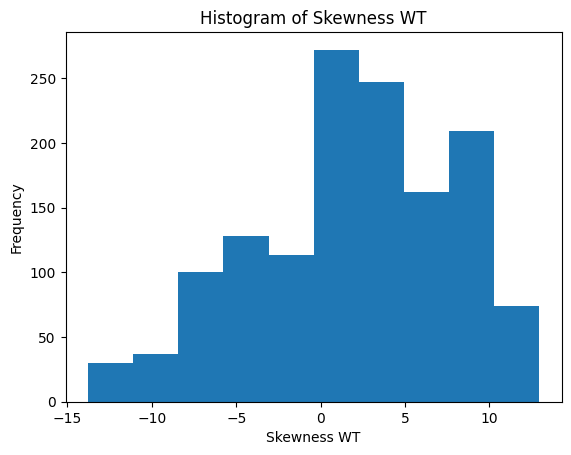

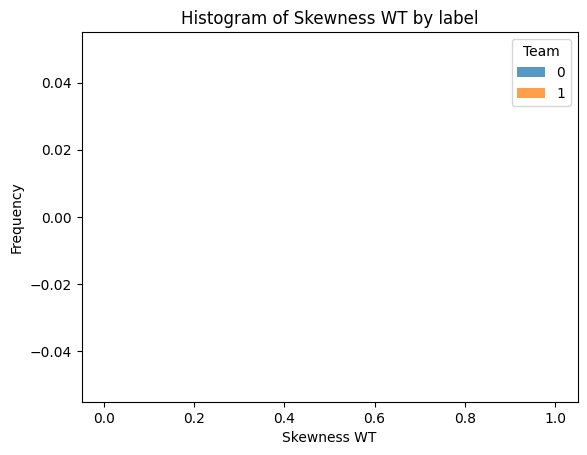

In [13]:
df.x2.hist(grid=False)
plt.title('Histogram of Skewness WT')
plt.xlabel('Skewness WT')
plt.ylabel('Frequency')
plt.savefig("./figures/analisi_exp/hist_skewness_WT")
plt.show()

plt.hist(df.loc[df['y'] == 0, 'x2'], alpha=0.75, label='0')
plt.hist(df.loc[df['y'] == 1, 'x2'], alpha=0.75, label='1')

plt.title('Histogram of Skewness WT by label')
plt.xlabel('Skewness WT')
plt.ylabel('Frequency')
plt.legend(title='Team')

plt.savefig("./figures/analisi_exp/hist_skewness_WT_by_label")
plt.show()

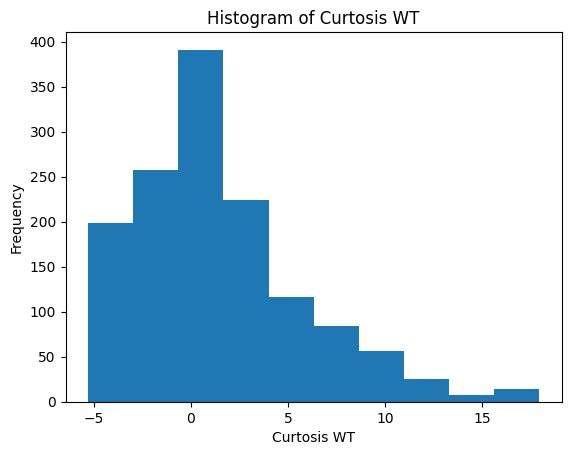

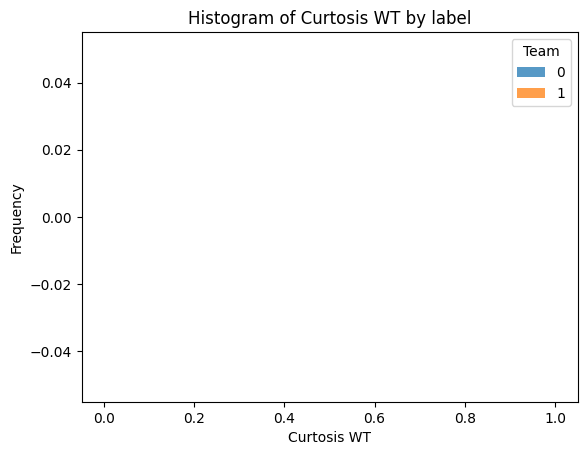

In [14]:
df.x3.hist(grid=False)
plt.title('Histogram of Curtosis WT')
plt.xlabel('Curtosis WT')
plt.ylabel('Frequency')
plt.savefig("./figures/analisi_exp/hist_curtosis_WT")
plt.show()

plt.hist(df.loc[df['y'] == 0, 'x3'], alpha=0.75, label='0')
plt.hist(df.loc[df['y'] == 1, 'x3'], alpha=0.75, label='1')

plt.title('Histogram of Curtosis WT by label')
plt.xlabel('Curtosis WT')
plt.ylabel('Frequency')
plt.legend(title='Team')

plt.savefig("./figures/analisi_exp/hist_curtosis_WT_by_label")
plt.show()

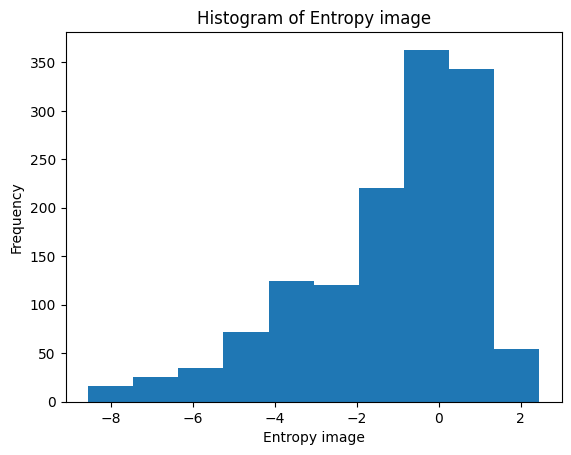

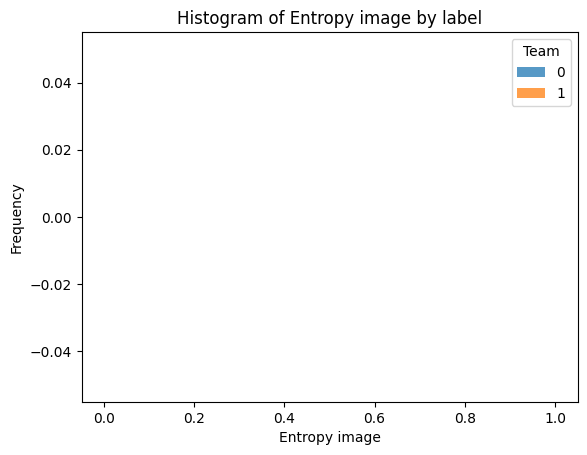

In [15]:
df.x4.hist(grid=False)
plt.title('Histogram of Entropy image')
plt.xlabel('Entropy image')
plt.ylabel('Frequency')
plt.savefig("./figures/analisi_exp/hist_entropy_img")
plt.show()

plt.hist(df.loc[df['y'] == 0, 'x4'], alpha=0.75, label='0')
plt.hist(df.loc[df['y'] == 1, 'x4'], alpha=0.75, label='1')

plt.title('Histogram of Entropy image by label')
plt.xlabel('Entropy image')
plt.ylabel('Frequency')
plt.legend(title='Team')

plt.savefig("./figures/analisi_exp/hist_entropy__img_by_label")
plt.show()

array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>],
       [<Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>]],
      dtype=object)

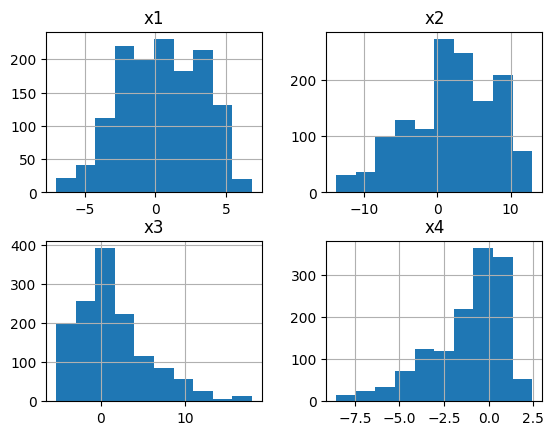

In [16]:
fig, axs = plt.subplots(2,2)

#create histogram for each column in DataFrame
df.iloc[: , 1:].hist(ax=axs)

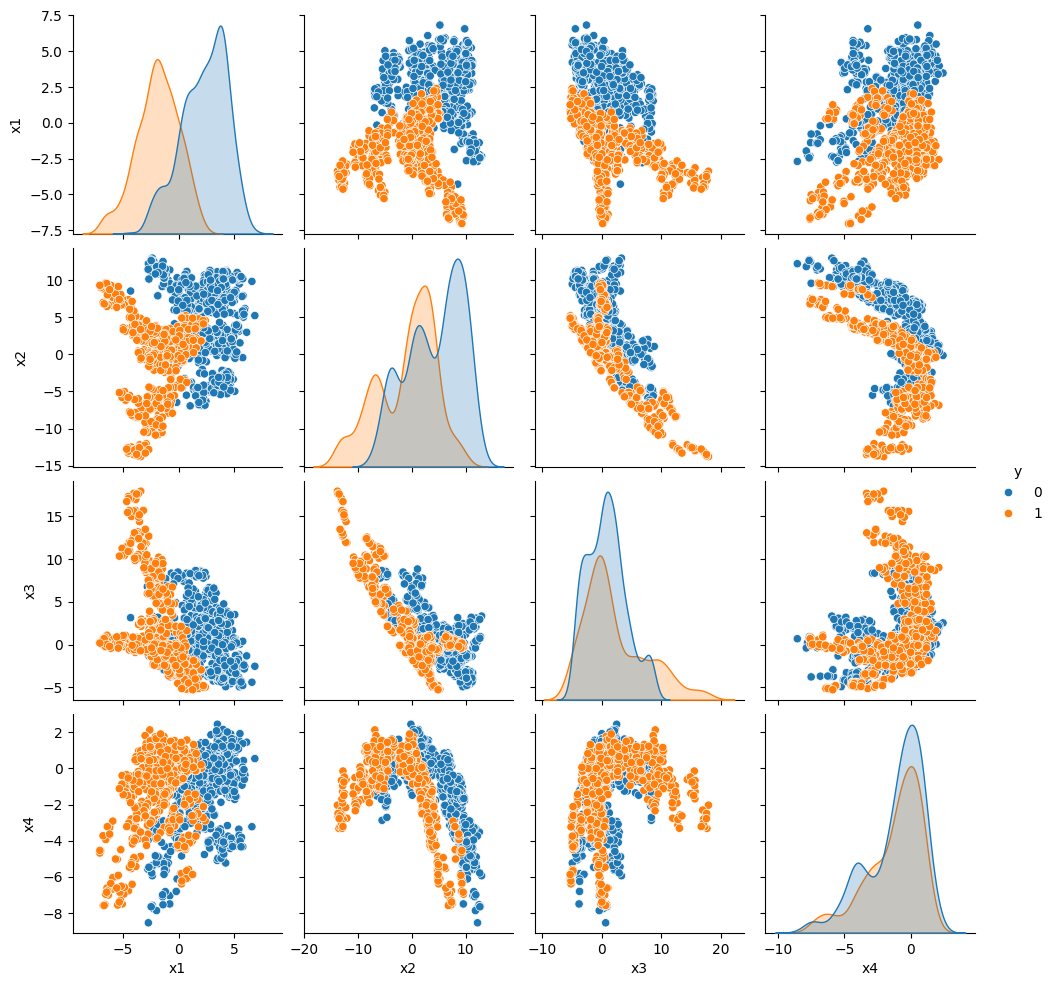

In [17]:
sns_plot = sns.pairplot(df, hue="y")
plt.savefig("./figures/analisi_exp/pair_plot")

### 2. Unsupervised Learning

Use PCA and plot the two first components colouring according with the class. Are the classes linearly separable in this projection? What happens when I applied k-means with two classes in this space? And if I use all the coordinates? Try also t-SNE for projection and DBSCAN for the clustering and comment on the results.

In [18]:
N = X.shape[0]  # Number of data points
nc = X.shape[1]  # Number of features/components

lbs_train = y_train.astype(str)
lbs_test = y_test.astype(str)

### PCA

In [19]:
sc = StandardScaler()
sc.fit(X_train)
Xs_train = sc.fit_transform(X_train)
Xs_test = sc.fit_transform(X_test)

#### Model Assessment: choose the number of PCs to keep

**Objective**: choose the final dimension $d$ of the transformed data.

1. Proportion of variance explained: given eigenvalues $\lambda_i$ of the covariance matrix and a threshold $t\in [0, 1]$, choose $d$ s.t. the ratio $\chi_d = \frac{\sum_{i=1}^d \lambda_i}{\sum_{i=1}^D \lambda_i} > t$

2. Check the existence of a gap in the spectrum of the covariance matrix.

Now, we apply PCA the same dataset, and retrieve all the components. We use the same px.scatter_matrix trace to display our results, but this time our features are the resulting principal components, ordered by how much variance they are able to explain.

The importance of explained variance is demonstrated in the example below. The subplot between PC3 and PC4 is clearly unable to separate each class, whereas the subplot between PC1 and PC2 shows a clear separation between each species.

In [20]:
# Performing Principal Component Analysis (PCA) using sklearn
pca = PCA()

# Fitting the PCA model to the scaled data
pca.fit(Xs_train)

# Transforming the original data to the principal components
projection = pca.transform(Xs_train)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

# Calculating the cumulative explained variance ratio
cumulative_variance = np.zeros(nc)
for i in range(nc):
    cumulative_variance[i] = np.sum(pca.explained_variance_ratio_[:i+1])

# Extracting eigenvalues and component indices
eigenvalues = pca.explained_variance_
components = np.arange(nc) + 1
display(eigenvalues)
components

array([2.18679588, 1.28752292, 0.34119044, 0.18866177])

array([1, 2, 3, 4])

In [21]:
labels = {str(i): f"PC {i+1}" for i in range(4)}
labels['color'] = 'label'

fig = px.scatter_matrix(
    projection,
    labels=labels,
    dimensions=range(4),
    color=lbs_train,
    width=800, 
    height=800
)
fig.update_traces(diagonal_visible=False)
fig.show()

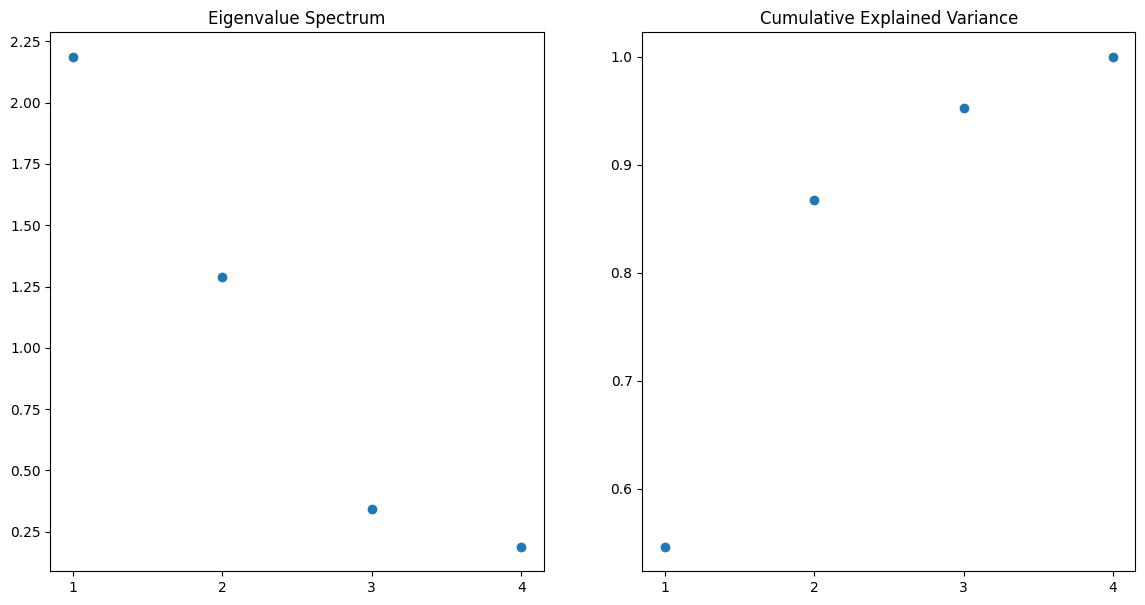

In [22]:
# Creating subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 7))

# Plotting the Spectrum
ax1.set_title('Eigenvalue Spectrum')
ax1.scatter(components, eigenvalues)
ax1.set_xticks(components)

# Plotting the Cumulative Explained Variance
ax2.set_title('Cumulative Explained Variance')
ax2.scatter(components, cumulative_variance)
ax2.set_xticks(components)

# Displaying the plots
plt.show()

In [23]:
# Determine the number of components based on different explained variance thresholds.
for threshold in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 0.999]:
    # Find the index where cumulative variance exceeds the threshold
    num_components = np.argmax(cumulative_variance - threshold > 0.) + 1

    # Print the threshold and the corresponding number of components
    print(f"Explained Variance Threshold: {threshold}, Number of Components: {num_components}")


Explained Variance Threshold: 0.8, Number of Components: 2
Explained Variance Threshold: 0.85, Number of Components: 2
Explained Variance Threshold: 0.9, Number of Components: 3
Explained Variance Threshold: 0.95, Number of Components: 3
Explained Variance Threshold: 0.97, Number of Components: 4
Explained Variance Threshold: 0.99, Number of Components: 4
Explained Variance Threshold: 0.999, Number of Components: 4


#### Visualize a subset of the principal components

When you will have too many features to visualize, you might be interested in only visualizing the most relevant components. Those components often capture a majority of the explained variance, which is a good way to tell if those components are sufficient for modelling this dataset.

In the example below, our dataset contains 8 features, but we only select the first 2 components.

#### 2D PCA Scatter Plot


In the previous examples, you saw how to visualize high-dimensional PCs. In this example, we show you how to simply visualize the first two principal components of a PCA, by reducing a dataset of 4 dimensions to 2D.

In [24]:
pca = PCA(n_components=2)

components = pca.fit_transform(Xs_train)

var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter(components, x=0, y=1, 
                color=lbs_train,
                labels={'0': 'PC 1', '1': 'PC 2'},
                title=f'Total Explained Variance: {var:.2f}%',
                width=800, height=800)
fig.show()

#### Plotting explained variance

Often, you might be interested in seeing how much variance PCA is able to explain as you increase the number of components, in order to decide how many dimensions to ultimately keep or analyze. This example shows you how to quickly plot the cumulative sum of explained variance for a high-dimensional dataset like Diabetes.

With a higher explained variance, you are able to capture more variability in your dataset, which could potentially lead to better performance when training your model.

In [25]:
pca = PCA()
pca.fit(Xs_train)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
    markers=True,
    width=600,
    height=400
)
fig.update_xaxes(type='category')

#### Visualize Loadings

It is also possible to visualize loadings using shapes, and use annotations to indicate which feature a certain loading original belong to. Here, we define loadings as:
$$
 loadings = eigenvectors\sqrt{eigenvalues}
$$

In [26]:
pca = PCA(n_components=2)
components = pca.fit_transform(Xs_train)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=lbs_train, width=800, height=800)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=1,
        arrowhead=1,
        arrowwidth=3,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
        font=dict(
            size=20,
            color="#000000"
            ),
    )
fig.show()

### KMeans

In [27]:
pca = PCA(n_components=2)
components = pca.fit_transform(Xs_train)

kmeans = KMeans(n_clusters = 2, random_state = 0, n_init='auto')

kmeans.fit(components)

fig = px.scatter(components, x=0, y=1, 
                color=kmeans.labels_.astype(str),
                labels={'0': 'PC 1', '1': 'PC 2'},
                title=f'PCA dataset - k-Means Clustering con k=2',
                width=800, height=800)
fig.show()

In [28]:
fig = px.scatter(components, x=0, y=1, 
                color=lbs_train,
                labels={'0': 'PC 1', '1': 'PC 2'},
                title=f'PCA dataset - k-Means Clustering con k=2',
                width=800, height=800)
fig.show()

In [29]:
kmeans.fit(Xs_train)

labels = {str(i): f"x{i+1}" for i in range(4)}
labels['color'] = 'label'

fig = px.scatter_matrix(
    Xs_train,
    labels=labels,
    dimensions=range(4),
    color=kmeans.labels_.astype(str),
    title=f'Full dataset - k-Means Clustering con k=2',
    width=800, 
    height=800
)
fig.update_traces(diagonal_visible=False)
fig.show()


### t-SNE

The t-SNE algorithm finds the similarity measure between pairs of instances in higher and lower dimensional space. After that, it tries to optimize two similarity measures. It does all of that in three steps.
1. t-SNE models a point being selected as a neighbor of another point in both higher and lower dimensions. It starts by calculating a pairwise similarity between all data points in the high-dimensional space using a Gaussian kernel. The points that are far apart have a lower probability of being picked than the points that are close together. 

2. Then, the algorithm tries to map higher dimensional data points onto lower dimensional space while preserving the pairwise similarities. 

3. It is achieved by minimizing the divergence between the probability distribution of the original high-dimensional and lower-dimensional. The algorithm uses gradient descent to minimize the divergence. The lower-dimensional embedding is optimized to a stable state.

The optimization process allows the creation of clusters and sub-clusters of similar data points in the lower-dimensional space that are visualized to understand the structure and relationship in the higher-dimensional data. 

In [30]:
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xs_train)

Now we will apply the t-SNE algorithm to the dataset and compare the results. 

After fitting and transforming data, we will display Kullback-Leibler (KL) divergence between the high-dimensional probability distribution and the low-dimensional probability distribution. 

Low KL divergence is a sign of better results.

In [31]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(Xs_train)
tsne.kl_divergence_

0.3450450301170349

In [32]:
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1])
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
    width=800,
    height=800
)
fig.show()

The result is quite better than PCA. We can clearly see three big clusters. 
As we can see, we have multiple clusters and sub-clusters. We can use this information to understand the pattern and come up with a strategy for retaining existing customers. 

t-SNE is a powerful visualization tool for revealing hidden patterns and structures in complex datasets. You can use it for images, audio, biologicals, and single data to identify anomalies and patterns. 

In this blog post, we have learned about t-SNE, a popular dimensionality reduction technique that can visualize high-dimensional non-linear data in a low-dimensional space. We have explained the main idea behind t-SNE, how it works, and its applications. Moreover, we showed some examples of applying t-SNE to synthetics and real datasets and how to interpret the results. 

t-SNE is a part of Unsupervised Learning, and the next natural step is to understand hierarchical clustering, PCA, Decorrelating, and discovering interpretable features. Learn all of the topics by taking our Unsupervised Learning in Python course.

### DBSCAN

In [33]:
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning

In [34]:
pca = PCA(n_components=2)
components = pca.fit_transform(Xs_train)

In [35]:
fig = px.scatter(components, x=0, y=1, 
                labels={'0': 'PC 1', '1': 'PC 2'},
                title=f'Diagramma dispersione PCs',
                width=800, height=800)
fig.show()

In [36]:
db = DBSCAN(eps=0.5, min_samples=10).fit(components)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 12


In [37]:
fig = px.scatter(components, x=0, y=1, 
                color=labels.astype(str),
                labels={'0': 'PC 1', '1': 'PC 2'},
                title=f'DBSCAN',
                width=800, height=800)
fig.show()

In [38]:
db = DBSCAN(eps=0.3, min_samples=20).fit(components)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 273


In [39]:
fig = px.scatter(components, x=0, y=1, 
                color=labels.astype(str),
                labels={'0': 'PC 1', '1': 'PC 2'},
                title=f'DBSCAN',
                width=800, height=800)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.90,
    traceorder="normal"
))
fig.show()

In [40]:
db = DBSCAN(eps=0.25, min_samples=5).fit(components)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 59


In [41]:
fig = px.scatter(components, x=0, y=1, 
                color=labels.astype(str),
                labels={'0': 'PC 1', '1': 'PC 2'},
                title=f'DBSCAN',
                width=800, height=800)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.90,
    traceorder="normal"
))
fig.show()

### 3. Supervised Learning

Generate a subset of the data of 372 elements that would be saved as test set. With the rest of the data generate the following models: Logistic Regression, Decision tree (use the ID3 algorithm), Naive Bayesian and k-NN. 

Investigate the effect of regularization (when possible) and use cross validation for setting the hyper-parameters when needed. 

Compare the performances in terms of accuracy, precision, recall and F1-score on the test set. Comment these results at the light of those obtained from the Unsupervised Learning analysis. Could you propose a way to improve these results?     


In [2]:
df = pd.read_csv('./dataset/data_banknote_authentication.txt', header=None)
X = df.iloc[:, -2].values
y = df.iloc[:, -1].values
df.pop(4)
df.rename(columns={0:'x1', 1:'x2', 2:'x3', 3:'x4'}, inplace=True)
features = ['x1', 'x2', 'x3', 'x4']
df.insert(0, 'y', y)
df.insert(1, 'x0', np.ones_like(y))
df

,y,x0,x1,x2,x3,x4
0,0,1,3.62160,8.66610,-2.8073,-0.44699
1,0,1,4.54590,8.16740,-2.4586,-1.46210
2,0,1,3.86600,-2.63830,1.9242,0.10645
3,0,1,3.45660,9.52280,-4.0112,-3.59440
4,0,1,0.32924,-4.45520,4.5718,-0.98880
...,...,...,...,...,...,...
1367,1,1,0.40614,1.34920,-1.4501,-0.55949
1368,1,1,-1.38870,-4.87730,6.4774,0.34179
1369,1,1,-3.75030,-13.45860,17.5932,-2.77710
1370,1,1,-3.56370,-8.38270,12.3930,-1.28230


In [3]:
def absolute_maximum_scale(series):
    return series / series.abs().max()

for col in df.columns:
    df[col] = absolute_maximum_scale(df[col])

In [4]:
def min_max_scale(ds):
    xmax = max(ds)
    xmin = min(ds)
    xscaled = [(x - xmin) / (xmax - xmin) for x in ds]
    return xscaled

In [5]:
def absolute_maximum_scale(series):
    """
    Scale each column in the DataFrame 'df_fin' by dividing the values by the absolute maximum value of that column.

    Args:
    series: A pandas Series or DataFrame column to be scaled.

    Returns:
    A scaled version of the input series with values ranging from -1 to 1 based on the maximum absolute value in the column.
    """
    return series / series.abs().max()

In [6]:
#Apply the 'absolute_maximum_scale' function to each column in the DataFrame 'df_fin'
for col in df.columns:
    df[col] = absolute_maximum_scale(df[col])

In [7]:
df["y"] = df["y"].astype(int)
df.head()

,y,x0,x1,x2,x3,x4
0,0,1.0,0.514278,0.629205,-0.156593,-0.052291
1,0,1.0,0.645532,0.592996,-0.137142,-0.171042
2,0,1.0,0.548984,-0.191555,0.107333,0.012453
3,0,1.0,0.490848,0.691406,-0.223747,-0.420486
4,0,1.0,0.046753,-0.323471,0.255017,-0.115673


In [8]:
label = y.astype(str)
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=372, random_state=1)

### Logistic regression

In [9]:
# SIGMOIDE
def sigmoidM(X, w):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    y = 1/(1+np.exp(-np.matmul(X,w)))
    return y

# NOR
def LogisticLoss(X, labels, w):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    y : array of dim n
        Vector representing the ground truth label of each data point
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    n = np.shape(X)[0]
    cost = -(1/n)*np.sum(labels*np.log(sigmoidM(X,w)) + (1-labels)*np.log(1-sigmoidM(X,w)))
    return cost

def GDLogistic(X, labels, iter, gamma, w_):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    labels : array of dim n
        Vector representing the ground truth label of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    """
    d = np.shape(X)  # d contains the shape of X, which is a tuple (n, d)
    cost = np.zeros(iter)  # Create an array to store the cost at each iteration
    w = w_
    W = np.zeros((d[1], iter))  # Create an array to store the weight vectors at each iteration
    
    for i in range(iter):
        W[:, i] = w  # Store the current weight vector in the W array
        # Update the weight vector using gradient descent
        w = w - (gamma / d[0]) * (np.transpose(X) @ (sigmoidM(X, w) - labels))
        # Compute and store the logistic loss for the current weight vector
        cost[i] = LogisticLoss(X, labels, w)

    return W, cost

# RIDGE
def RidgeLogLoss(X, labels, w, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line
    lam : float
        Weight of the L2 penalty term
    """
    n = np.shape(X)[0]
    cost = -(1/n)*np.sum(labels*np.log(sigmoidM(X,w)) + (1-labels)*np.log(1-sigmoidM(X,w))) + lam*np.dot(w,w)
    return cost

def GDRidgeLogistic(X, labels, iter, gamma, lam, w_):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    labels : array of dim n
        Vector representing the ground truth label of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    lam : float
        Weight of the penalty term
    """
    d = np.shape(X)  # d contains the shape of X, which is a tuple (n, d)
    cost = np.zeros(iter)  # Create an array to store the cost at each iteration
    w = w_
    W = np.zeros((d[1], iter))  # Create an array to store the weight vectors at each iteration
    for i in range(iter):
        W[:, i] = w  # Store the current weight vector in the W array
        # Update the weight vector using gradient descent
        w = w - (gamma / d[0]) * (np.transpose(X) @ (sigmoidM(X, w) - labels) + 2*lam*w)
        # Compute and store the logistic loss for the current weight vector
        cost[i] = RidgeLogLoss(X, labels, w, lam)

    return W, cost

#LASSO
def LassoLogLoss(X, labels, w, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line
    lam : float
        Weight of the L1 penalty term
    """
    n = np.shape(X)[0]
    cost = -(1/n)*np.sum(labels*np.log(sigmoidM(X,w)) + (1-labels)*np.log(1-sigmoidM(X,w))) + lam*np.sum(np.abs(w))
    return cost

def L1_subgradient(z):
    """
    Compute the subgradient of the absolute value function element-wise.

    Parameters:
    ----------
    z : array-like
        Input array for which the subgradient is calculated.

    Returns:
    ----------
    g : array-like
        Subgradient of the absolute value function applied element-wise to `z`.
    """
    # Create an array g of the same shape as z, initialized with all 1s.
    g = np.ones(z.shape)

    # Check each element of z.
    for i in range(z.shape[0]):
    # If the element is negative, set the corresponding element in g to -1.
       if z[i] < 0.:
          g[i] = -1.0
    # If the element is zero, set the corresponding element in g to 0.
       elif z[i] == 0.:
         g[i] = 0.0


    # Return the resulting array g, representing the subgradient.
    return g

def LassoGradient(w, lam):
    return lam * L1_subgradient(w)

def GDLassoLogistic(X, labels, iter, gamma, lam, w_):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    labels : array of dim n
        Vector representing the ground truth label of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    lam : float
        Weight of the penalty term
    """
    d = np.shape(X)  # d contains the shape of X, which is a tuple (n, d)
    cost = np.zeros(iter)  # Create an array to store the cost at each iteration
    w = w_
    W = np.zeros((d[1], iter))  # Create an array to store the weight vectors at each iteration
    for i in range(iter):
        W[:, i] = w  # Store the current weight vector in the W array
        # Update the weight vector using gradient descent
        w = w - (gamma / d[0]) * (np.transpose(X) @ (sigmoidM(X, w) - labels) + LassoGradient(w, lam))
        # Compute and store the logistic loss for the current weight vector
        cost[i] = LassoLogLoss(X, labels, w, lam)

    return W, cost

In [10]:
def SquareLoss(X, y, w):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line
    """
    return LA.norm(y-X@w,2)

In [11]:
iters = 1000
lr1 = 0.01
lr2 = 0.001
lr3 = 0.0001


np.random.seed(1234)
w = np.random.uniform(0, 0.1, np.shape(X_train)[1])  # Initialize w with random values

W1, cost1 = GDLogistic(X_train, y_train, iters, lr1, w)
W2, cost2 = GDLogistic(X_train, y_train, iters, lr2, w)
W3, cost3 = GDLogistic(X_train, y_train, iters, lr3, w)


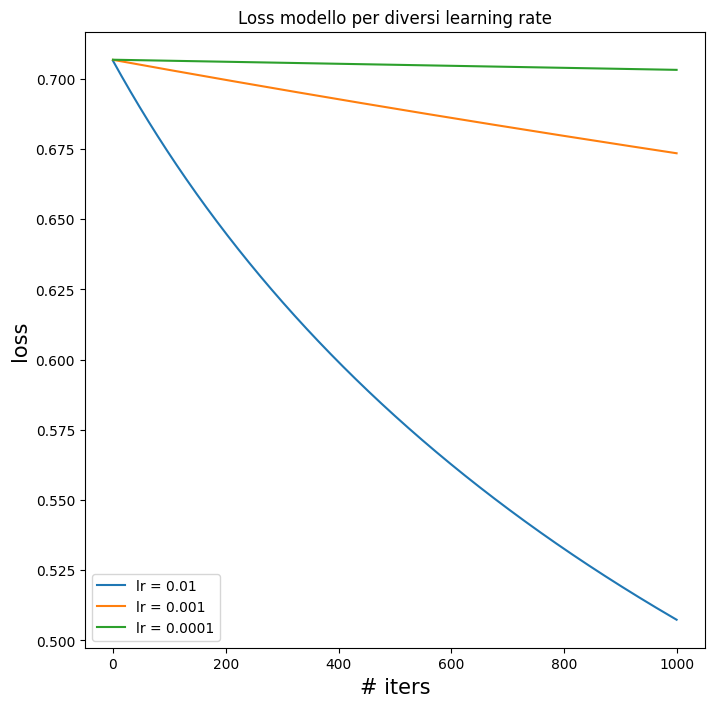

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.arange(iters),
        cost1,
        label='lr = 0.01')
ax.plot(np.arange(iters),
        cost2,
        label='lr = 0.001')
ax.plot(np.arange(iters),
        cost3,
        label='lr = 0.0001')
ax.set_ylabel('loss',
              fontsize=15)
ax.set_xlabel('# iters',
              fontsize=15)
ax.set_title(f"Loss modello per diversi learning rate")
ax.legend()
fig.savefig('./figures/SL/loss_al_variare_del_lr')


In [13]:
def get_conf_matrix(y_pred, y_true):
    """ Return the confusion matrix
    
    y_pred (int): array 1 x d
        predicted label
        
    y_true: array 1 x d
        true label
        
    return (array 3 x 3 int) 
    """  
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for yt, yp in zip(y_true, y_pred):
        if yp == yt:
            if yp == 1:
                tp += 1
            else:
                tn += 1
        else:
            if yp == 1:
                fp += 1
            else:
                fn += 1
    
    conf_matrix = [
        [len(y_true), tp+fp, fn+tn],
        [tp+fn, tp, fn],
        [fp+tn, fp, tn]]

    return np.array(conf_matrix)

def predict(X, w, th=0.5):
    y_pred = sigmoidM(X, w)
    return y_pred >= th
    

def weird_division(n, d):
    return n / d if d else 0

In [14]:
iters = 1000
gamma = 0.01
np.random.seed(1234)
w = np.random.uniform(0, 0.01, np.shape(X_train)[1])  # Initialize w with random values

W, cost = GDLogistic(X_train, y_train, iters, gamma, w)

w=W[:,iters-1]

if np.sum(y_test) > (len(y_test)/2):
    y_blm = np.ones(len(y_test))
else:
    y_blm = np.zeros(len(y_test))

y_pred_no_reg = predict(X_test, w)

In [15]:
cm_blm = get_conf_matrix(y_blm, y_test)
cm_no_reg = get_conf_matrix(y_pred_no_reg, y_test)
cm_blm, cm_no_reg

(array([[372,   0, 372],
        [166,   0, 166],
        [206,   0, 206]]),
 array([[372, 127, 245],
        [166, 120,  46],
        [206,   7, 199]]))

In [16]:
header = ["Accuracy","Precision","Recall","F1-score"]
data = list()
for cf in [cm_blm, cm_no_reg]:
    aux = [weird_division(cf[1,1]+cf[2,2],cf[0,0]), weird_division(cf[1,1],cf[0,1]), weird_division(cf[1,1],cf[1,0]), weird_division((2*cf[1,1]),((2*cf[1,1])+cf[2,1]+cf[1,2]))]
    data.append(aux)


pd.DataFrame(data, ['Base-Line-Model', 'Logistic regression without regularization'], header)

,Accuracy,Precision,Recall,F1-score
Base-Line-Model,0.553763,0.000000,0.000000,0.000000
Logistic regression without regularization,0.857527,0.944882,0.722892,0.819113


In [17]:
def KFoldCV(Xtr, ytr, K, gamma, w, iters):
    points = Xtr.shape[0] # total training points
    fold_size = int(np.ceil(points/K)) # size of each K-fold
    rand_idx = np.random.choice(points, size=points, replace=False)
    performance = np.zeros((K,4))
    # K-fold CV runs
    first=0
    for fold in range(K):
        # create a mask to distinguish train and validation set for this run
        flags = np.zeros(points)
        flags[first:first + fold_size] = 1
        # construct the  training and validation set
        X = Xtr[rand_idx[flags==0]]
        y = ytr[rand_idx[flags==0]]
        X_val = Xtr[rand_idx[flags==1]]
        y_val = ytr[rand_idx[flags==1]]

        # compute the training error of the Ridge regression for the given value of lambda
        W, L = GDLogistic(X, y, iters, gamma, w)
        
        y_pred = predict(X_val, W[:, np.argmin(L)])
        cf = get_conf_matrix(y_pred, y_val)
        performance[fold,:] = [weird_division(cf[1,1]+cf[2,2],cf[0,0]), # Accuracy
                               weird_division(cf[1,1],cf[0,1]),  # Precision
                               weird_division(cf[1,1],cf[1,0]), # Recall
                               weird_division((2*cf[1,1]),((2*cf[1,1])+cf[2,1]+cf[1,2]))] # F1-score
        first = first + fold_size
    performance = np.mean(performance, axis=0)
    return performance

In [18]:
K = 5
gamma=0.01
iters=1000
w = np.random.uniform(0, 0.01, np.shape(X_train)[1])  # Initialize w with random values
perf = KFoldCV(X_train, y_train, K, gamma, w, iters)

In [19]:
perf

array([0.841     , 0.93489232, 0.68965492, 0.79315664])

In [24]:
def KFoldCVRLS(Xtr, ytr, K, gamma, w, iters, lam=[1]):
    num_hpar = len(lam) # number of possible values for the hyperparameter
    points = Xtr.shape[0] # total training points
    fold_size = int(np.ceil(points/K)) # size of each K-fold
    tr_mean = np.zeros(num_hpar)
    val_mean = np.zeros(num_hpar)
    tr_std = np.zeros(num_hpar)
    val_std = np.zeros(num_hpar)
    rand_idx = np.random.choice(points, size=points, replace=False)
    train_loss = np.zeros((num_hpar,K))
    val_loss = np.zeros((num_hpar,K))
    for l_idx, l in enumerate(lam):
        first = 0
        # K-fold CV runs
        for fold in range(K):
            # create a mask to distinguish train and validation set for this run
            flags = np.zeros(points)
            flags[first:first + fold_size] = 1
            # construct the  training and validation set
            X = Xtr[rand_idx[flags==0]]
            y = ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            y_val = ytr[rand_idx[flags==1]]

            # compute the training error of the Ridge regression for the given value of lambda
            W, L = GDLassoLogistic(X, y, iters, l, gamma, w)
            train_loss[l_idx, fold] = L[-1]

            # compute the validation error of the regression for the given value of lambda
            val_error = LassoLogLoss(X_val, y_val, W[:, -1],l)
            val_loss[l_idx, fold] = val_error
            
            first = first + fold_size

        # summarize performance metrics
        tr_mean[l_idx] = np.mean(train_loss[l_idx,:])
        val_mean[l_idx] = np.mean(val_loss[l_idx,:])

        tr_std[l_idx] = np.std(train_loss[l_idx,:])
        val_std[l_idx] = np.std(val_loss[l_idx,:])

    best_par_idx = np.argmin(val_mean)
    best_par = lam[best_par_idx]

    return best_par, val_mean, val_std, tr_mean, tr_std, train_loss, val_loss

(5,)


C:\Users\abdul\AppData\Local\Temp\ipykernel_24360\2903861286.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


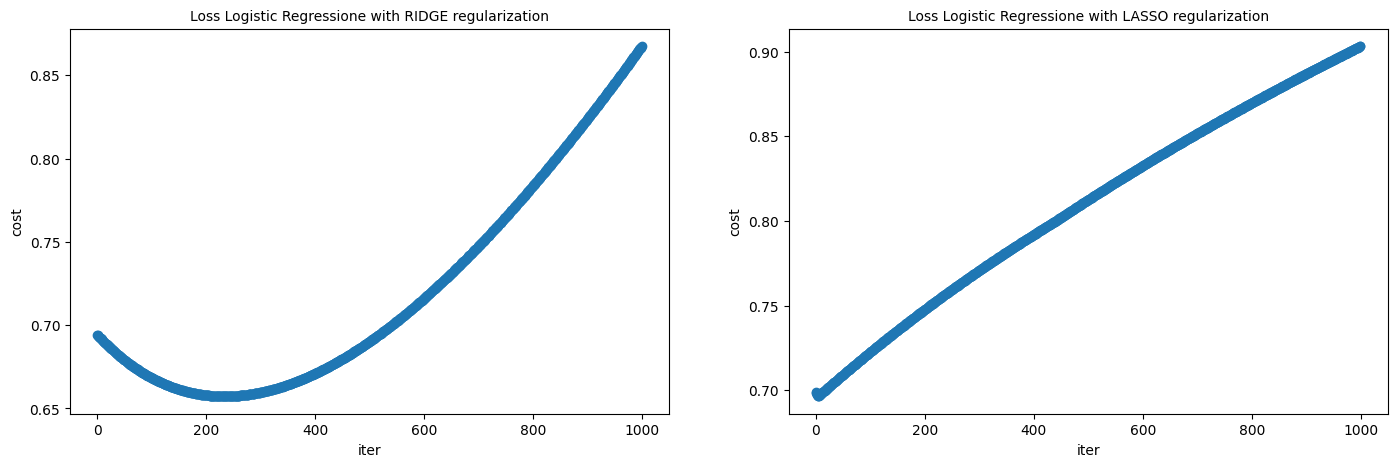

In [25]:
iter = 1000
gamma = 0.01
lam = 0.2

np.random.seed(1234)
#np.random.seed(666)
w = np.random.uniform(0, 0.01, np.shape(X_train)[1])  # Initialize w with random values
print(w.shape)
#w = np.zeros(np.shape(X_train)[1])  # Initialize w with random values

WR, costR = GDRidgeLogistic(X_train, y_train, iter, gamma, lam, w)
WL, costL = GDLassoLogistic(X_train, y_train, iter, gamma, lam, w)

costs = [["RIDGE", costR], ["LASSO", costL]]

fig, axs = plt.subplots(1, 2)

for ax, cost in zip(axs, costs):
    ax.plot(cost[1], 'o', ls='-')
    ax.set_xlabel("iter")
    ax.set_ylabel("cost")
    ax.set_title(f"Loss Logistic Regressione with {cost[0]} regularization")
    ax.title.set_size(10)
fig.set_size_inches(17,5)
fig.show()
fig.savefig("Loss_plots_reg")

In [26]:
print(f"w_ : {W1[:,-1]}\nwR : {WR[:,-1]}\nwL : {WL[:, -1]}")
pd.DataFrame([W1[:,-1], WR[:,-1], WL[:,-1]])

w_ : [-0.10585444 -1.12328359 -0.65403313  0.09499588  0.0309786 ]
wR : [-0.10393308 -1.15624995 -0.69073317  0.02751381 -0.03082876]
wL : [-0.1032824  -1.15688442 -0.69070016  0.02573744 -0.0303759 ]


,0,1,2,3,4
0,-0.105854,-1.123284,-0.654033,0.094996,0.030979
1,-0.103933,-1.156250,-0.690733,0.027514,-0.030829
2,-0.103282,-1.156884,-0.690700,0.025737,-0.030376


In [32]:
K = 5
gamma=0.001
iters=200
lam=np.linspace(0,1,11)
print('Lambda is chosen among: ', lam)
w = np.random.uniform(0, 0.01, np.shape(X_train)[1])  # Initialize w with random values
best_par, val_mean, val_std, tr_mean, tr_std, train_loss, val_loss = KFoldCVRLS(X_train, y_train, K, gamma, w, iters, lam)

print('Best lambda: ', best_par)

Lambda is chosen among:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Best lambda:  0.0


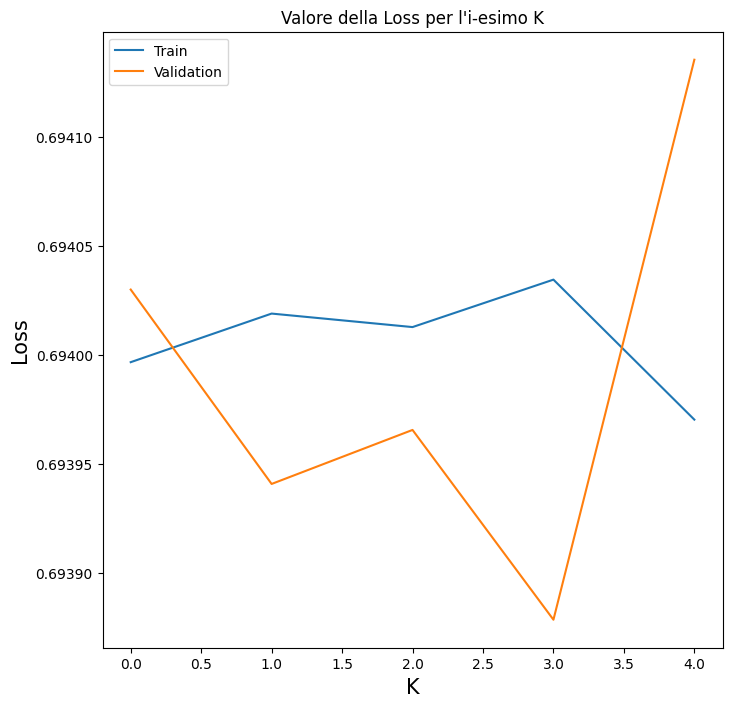

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.arange(K),
        train_loss[0],
        label='Train')
ax.plot(np.arange(K),
        val_loss[0],
        label='Validation')

ax.set_ylabel('Loss',
              fontsize=15)
ax.set_xlabel('K',
              fontsize=15)
plt.legend()
ax.set_title(f"Valore della Loss per l'i-esimo K")
fig.savefig('./figures/SL/ridge_k_loss_plot')

In [69]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


In [70]:
#split dataset in features and target variable
feature_cols = ['x1', 'x2', 'x3', 'x4']
X = df[feature_cols] # Features
y = df.y # Target variable

In [71]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [72]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9865591397849462


In [73]:
from sklearn.naive_bayes import GaussianNB

# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

# Predict Output
predicted = model.predict([X_test[6]])

print("Actual Value:", y_test[6])
print("Predicted Value:", predicted[0])

Actual Value: 0
Predicted Value: 0


In [74]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

y_pred = model.predict(X_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.8494623655913979
F1 Score: 0.8495549227667039


In [75]:
from sklearn.neighbors import KNeighborsClassifier

In [76]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)

In [77]:
y_pred_mg = model.predict(X_test)
y_pred_dt = clf.predict(X_test)
y_pred_knn = knn.predict(X_test)


In [78]:
cm_mg = get_conf_matrix(y_pred_mg, y_test)
cm_dt = get_conf_matrix(y_pred_dt, y_test)
cm_knn = get_conf_matrix(y_pred_knn, y_test)

In [80]:
header = ["Accuracy","Precision","Recall","F1-score"]
data = list()
for cf in [cm_blm, cm_mg, cm_dt, cm_knn]:
    aux = [weird_division(cf[1,1]+cf[2,2],cf[0,0]), weird_division(cf[1,1],cf[0,1]), weird_division(cf[1,1],cf[1,0]), weird_division((2*cf[1,1]),((2*cf[1,1])+cf[2,1]+cf[1,2]))]
    data.append(aux)


pd.DataFrame(data, ['Base-Line-Model', 'Naive-Bayes', "Decision Tree", "KNN"], header)

,Accuracy,Precision,Recall,F1-score
Base-Line-Model,0.553763,0.000000,0.000000,0.000000
Naive-Bayes,0.849462,0.835366,0.825301,0.830303
Decision Tree,0.986559,0.982036,0.987952,0.984985
KNN,1.000000,1.000000,1.000000,1.000000


In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

clf_reg = LogisticRegression().fit(X_train, y_train)
y_score1 = clf.predict_proba(X_test)[:,1]
y_score2 = clf_reg.predict_proba(X_test)[:,1]
y_score3 = model.predict_proba(X_test)[:,1]
y_score4 = knn.predict_proba(X_test)[:,1]

In [84]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_score3)
false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_test, y_score4)

In [86]:
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score1))
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score2))
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score3))
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score4))

roc_auc_score for DecisionTree:  0.9866943502163995
roc_auc_score for Logistic Regression:  0.9974265996022927
roc_auc_score for Logistic Regression:  0.9428295707100245
roc_auc_score for Logistic Regression:  1.0


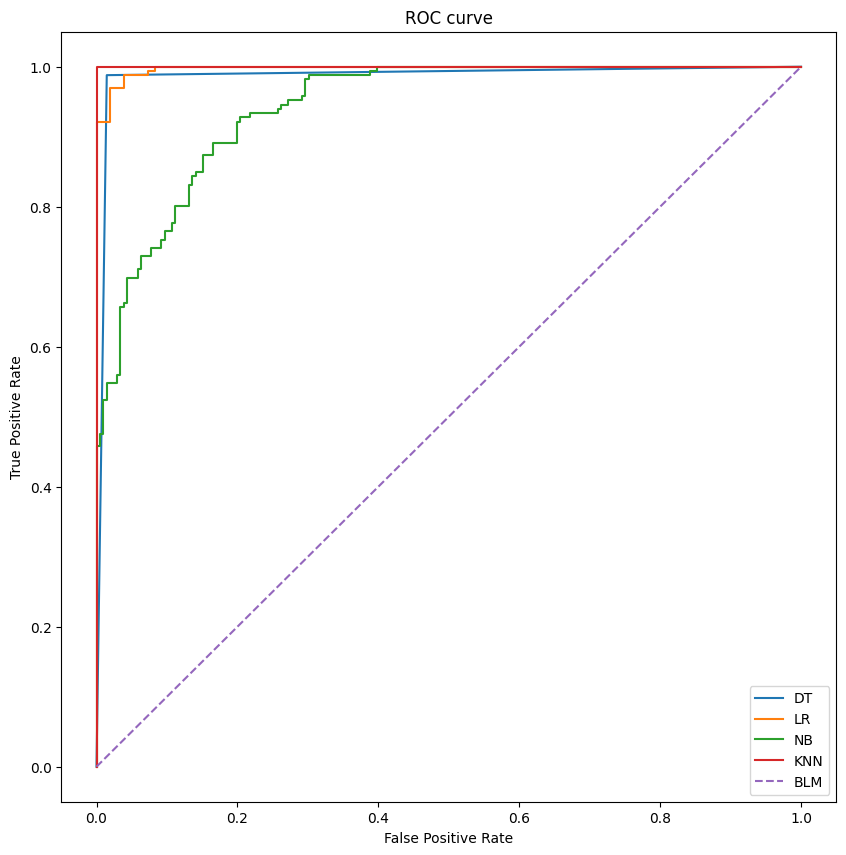

In [93]:
plt.subplots(1, figsize=(10,10))
plt.title('ROC curve')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot(false_positive_rate3, true_positive_rate3)
plt.plot(false_positive_rate4, true_positive_rate4)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(["DT", "LR", "NB", "KNN", "BLM"])
plt.show()